In [2]:
from pipeline.data_access.dao.sussex_huawei_dao import SussexHuaweiDAO
from pipeline.feature_engineering.preprocessing.sussex_huawei_preprocessor import SussexHuaweiPreprocessor
from pipeline.feature_engineering.feature_extraction.baseline_extractor import BaselineExtractor
import matplotlib as plt
import seaborn as sns

In [3]:
dao = SussexHuaweiDAO()
preprocessor = SussexHuaweiPreprocessor()
extractor = BaselineExtractor()

In [4]:
# 1. Load Data
label_column_names = ['coarse_label', 'fine_label', 'road_label']
labels = dao.read_data(
            './data_sets/sussex_huawei/User1/220617/Label.txt', #TODO: Pack in config/.env
            column_names=label_column_names, use_columns=[1, 2, 3])
data_column_names = ['time', 'acceleration_x', 'acceleration_y', 'acceleration_z', #TODO: Pack in config/.env
                             #'gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                             #'magnetometer_x', 'magnetometer_y', 'magnetometer_z',
                             'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z',
                             'gravity_x', 'gravity_y', 'gravity_z',
                             #'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                             ]
data = dao.read_data(
        './data_sets/sussex_huawei/User1/220617/Bag_Motion.txt', #TODO: Pack in config/.env
        column_names=data_column_names, use_columns=[0,1,2,3,10,11,12,13,14,15,16]) #4,5,6,7,8,9,17,18,19


In [5]:
# 2. Preprocessing

# 2.1 Convert unix time (ms) to date time
data = preprocessor.convert_unix_to_datetime(data, column = 'time', unit = 'ms')

# 2.2 Label data and remove NaNs
data = preprocessor.label_data(data, labels)
data = preprocessor.remove_nans(data, replacement_mode='del_row')

# 2.3 Normalization
acelerometer_columns = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gravity_columns = ['gravity_x', 'gravity_y', 'gravity_z']
orientation_columns = ['orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='gravity', 
            target_columns = acelerometer_columns,
            args = gravity_columns)

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='orientation', 
            target_columns = acelerometer_columns,
            args = orientation_columns)


data = preprocessor.znormalize_quantitative_data(data, data_column_names[1:])
#data = preprocessor.min_max_normalize_quantitative_data(data, data_column_names[1:])

# 2.4 Segment data
# Coarse Label: Null=0, Still=1, Walking=2, Run=3, Bike=4, Car=5, Bus=6, Train=7, Subway=8
# Road Label: City=1, Motorway=2, Countryside=3, Dirt road=4, Null=0
selected_coarse_labels = [5]
selected_road_labels = [1, 3]
car_segments = preprocessor.segment_data(data, mode='labels', 
                                 label_column='coarse_label', 
                                 args=selected_coarse_labels)

data_segments = []
for car_segment in car_segments:
        road_segments = preprocessor.segment_data(car_segment, mode='labels', 
                                  label_column='road_label',
                                  args=selected_road_labels
                                )
        for road_segment in road_segments:
            data_segments.append(road_segment)
            
# 2.5 Low Pass filtering -> #100 Hz to 10 Hz
for ind in range(len(data_segments)):
    data_segments[ind] = data_segments[ind].set_index('time')
    data_segments[ind] = preprocessor.resample_quantitative_data(data_segments[ind], freq='1000ms')
    
# 2.6 Outlier removal:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.remove_outliers_from_quantitative_data(
        data_segments[ind],
        replacement_mode = 'quantile',
        columns = acelerometer_columns,
        quantile = 0.99
    )
    
# 2.7 Dimensionality reduction:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.reduce_quantitativ_data_dimensionality(
        data = data_segments[ind],
        mode ='euclidean',
        columns = acelerometer_columns,
        reduced_column_name = 'acceleration_abs'
    )

1


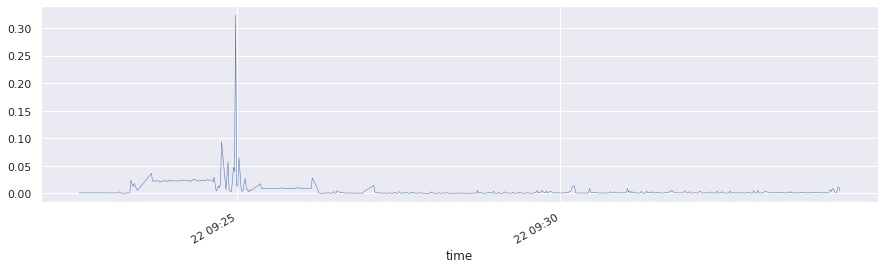

In [6]:
# Visual anlaysis:
sns.set(rc={'figure.figsize':(15, 4)})
data_segments[0]['acceleration_abs'].plot(linewidth=0.5);
print(data_segments[0]['road_label'].iloc[0]); # 1 = City



3


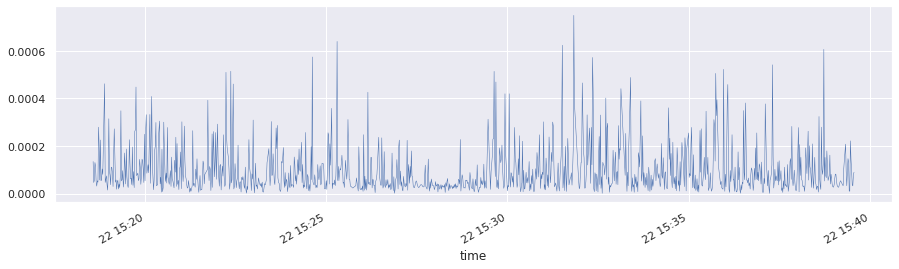

In [7]:
sns.set(rc={'figure.figsize':(15, 4)})
data_segments[5]['acceleration_abs'].plot(linewidth=0.5);
print(data_segments[5]['road_label'].iloc[0]); # 3 = Country

In [13]:
# 3. Feature Extraction

#3.1 Prepare for Basline Extractor
selected_columns = ['acceleration_abs', 'road_label']
data = preprocessor.de_segment_data(data_segments, selected_columns)
        
#Encode categorical to binary
data = preprocessor.encode_categorical_features(data = data, 
                                                mode = 'custom_function', 
                                                columns = ['road_label'],
                                                encoding_function = lambda x :  (x  > 2.0).astype(int)
                                               )


# Generate label vector y and feature matrix X.
# We need at least 2 classes to learn features for tsfresh
y = data[['road_label']].reset_index(drop=True)
data['id'] = range(1, len(data) + 1)
y['id'] = data['id']
y['road_label'].index=list(y['id'])

# 3.2 Extract feature matrix
# Read https://github.com/blue-yonder/tsfresh/issues/444 for info about the warnings
X = extractor.extract_features(data = data, args = ['id', y['road_label'], 16])

Feature Extraction: 100%|██████████| 80/80 [00:47<00:00,  1.69it/s]
 'acceleration_abs__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'acceleration_abs__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 ... 'road_label__spkt_welch_density__coeff_2'
 'road_label__spkt_welch_density__coeff_5'
 'road_label__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [33]:
# 4. Train and select a model

# 4.1 Random Forrests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


keys = X.keys()
keys = keys[int(len(keys)*0.5):int(len(keys))-2]
print(keys[int(len(keys)*0.5):int(len(keys))-2])

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X[keys], y)  

# Score function of sklearns RandomForrests classifier that is called by cross_val_score:
# "Returns the mean accuracy on the given test data and labels.""
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
score = cross_val_score(clf, X, y['road_label'], cv=10)
print(score)

Index(['road_label__abs_energy', 'acceleration_abs__median',
       'acceleration_abs__quantile__q_0.1',
       'acceleration_abs__quantile__q_0.2',
       'acceleration_abs__quantile__q_0.3',
       'acceleration_abs__quantile__q_0.4',
       'acceleration_abs__quantile__q_0.6',
       'acceleration_abs__quantile__q_0.7'],
      dtype='object', name='variable')
0.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
# 4.2 Super Vector Machine (SVM)
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X[keys], y['road_label']) 
y2 = clf.predict(X[keys])

score = cross_val_score(clf, X, y['road_label'], cv=10)
print(score)

0.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [37]:
# 4.3  CART Decision Tree (similar to C4.5)
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X[keys], y['road_label']) 

score = cross_val_score(clf, X, y['road_label'], cv=10)
print(score)

0.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [38]:
# 4.4 Multi Layered Perceptron
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X[keys], y['road_label']) 

score = cross_val_score(clf, X, y['road_label'], cv=10)
print(score)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
